In [22]:
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import pandas as pd
pd.set_option("display.max_columns", 500)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# Import Data

In [23]:
conn = sqlite3.connect("eia")
cursor = conn.cursor()


In [24]:
df = pd.DataFrame(cursor.execute("""select * from combined4""").fetchall())
df.columns = [description[0] for description in cursor.description]

In [25]:
df = df.drop(columns=["index"])

In [26]:
df.head()

,average_ash_content,average_heat_content,average_mercury_content,average_sulfur_content,chlorine_content,coalmine_county,coalmine_msha_id,coalmine_name,coalmine_state,coalmine_type,contract_expiration_date,contract_type,energy_source,fuel_cost,fuel_group,moisture_content,month,natural_gas_delivery_contract_type,natural_gas_supply_contract_type,natural_gas_transportation_service,operator_id,operator_name,plant_id,plant_name,plant_state,primary_transportation_mode,purchase_type,quantity,regulated,reporting_frequency,secondary_transportation_mode,supplier,year,plant_id_gen,combined_heat_and_power_plant,nuclear_unit_id,plant_name_gen,operator_name_gen,operator_id_gen,state_gen,census_region,nerc_region,reserved_,naics_code,eia_sector_number,sector_name,reported_prime_mover,reported_fuel_type_code,aer_fuel_type_code,reserved_1,reserved_2,physical_unit_label,total_fuel_consumption_quantity,electric_fuel_consumption_quantity,total_fuel_consumption_mmbtu,elec_fuel_consumption_mmbtu,net_generation_megawatthours,year_gen,quantity_gen,elec_quantity_gen,mmbtu_per_unit_gen,tot_mmbtu_gen,elec_mmbtu_gen,netgen_gen,year_month
0,5.4,23.100,NaN,0.49,NaN,IMP,0,MINA PRIBBENOW,CL,SU,408.0,C,BIT,213.5,Coal,NaN,1,None,None,F,195,Alabama Power Co,3,Barry,AL,RV,None,259412,REG,M,None,INTEROCEAN COAL,2008,3,N,0,Barry,Alabama Power Co,195,AL,ESC,SERC,None,22,1,Electric Utility,ST,BIT,COL,None,None,short tons,4208251,4208251,94561606,94561606,9472859,2008,340778,340778,22.59,7697153,7697153,778699,2008-01
1,5.7,22.800,NaN,0.48,NaN,IMP,0,MINA PRIBBENOW,CL,SU,408.0,C,BIT,211.5,Coal,NaN,1,None,None,F,195,Alabama Power Co,3,Barry,AL,RV,None,52241,REG,M,None,INTEROCEAN COAL,2008,3,N,0,Barry,Alabama Power Co,195,AL,ESC,SERC,None,22,1,Electric Utility,ST,BIT,COL,None,None,short tons,4208251,4208251,94561606,94561606,9472859,2008,340778,340778,22.59,7697153,7697153,778699,2008-01
2,0.0,1.039,NaN,0.00,NaN,None,0,None,None,None,None,C,NG,863.1,Natural Gas,NaN,1,None,None,F,195,Alabama Power Co,3,Barry,AL,PL,None,2783619,REG,M,None,BAY GAS PIPELINE,2008,3,N,0,Barry,Alabama Power Co,195,AL,ESC,SERC,None,22,1,Electric Utility,CA,NG,NG,None,None,mcf,3433,3433,3559,3559,1609033,2008,2400,2400,1.04,2489,2489,146327,2008-01
3,0.0,1.039,NaN,0.00,NaN,None,0,None,None,None,None,C,NG,863.1,Natural Gas,NaN,1,None,None,F,195,Alabama Power Co,3,Barry,AL,PL,None,2783619,REG,M,None,BAY GAS PIPELINE,2008,3,N,0,Barry,Alabama Power Co,195,AL,ESC,SERC,None,22,1,Electric Utility,CT,NG,NG,None,None,mcf,30932077,30932077,32090118,32090118,2858195,2008,2781102,2781102,1.04,2884003,2884003,244784,2008-01
4,0.0,1.039,NaN,0.00,NaN,None,0,None,None,None,None,C,NG,863.1,Natural Gas,NaN,1,None,None,F,195,Alabama Power Co,3,Barry,AL,PL,None,2783619,REG,M,None,BAY GAS PIPELINE,2008,3,N,0,Barry,Alabama Power Co,195,AL,ESC,SERC,None,22,1,Electric Utility,ST,NG,NG,None,None,mcf,837652,837652,871270,871270,87265,2008,109281,109281,1.04,113543,113543,11487,2008-01


In [77]:
df.plant_id = df.plant_id.astype(str)


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440666 entries, 0 to 440665
Data columns (total 65 columns):
average_ash_content                   440666 non-null float64
average_heat_content                  440666 non-null float64
average_mercury_content               193405 non-null float64
average_sulfur_content                440666 non-null float64
chlorine_content                      9106 non-null float64
coalmine_county                       137172 non-null object
coalmine_msha_id                      440666 non-null int64
coalmine_name                         136322 non-null object
coalmine_state                        138337 non-null object
coalmine_type                         138122 non-null object
contract_expiration_date              340240 non-null object
contract_type                         247249 non-null object
energy_source                         440666 non-null object
fuel_cost                             440666 non-null float64
fuel_group                      

# Just Get Natural Gas Entries

In [124]:
ng_fields = [ 'contract_type', 'fuel_cost', 'natural_gas_delivery_contract_type', 'natural_gas_supply_contract_type', 'natural_gas_transportation_service', 'operator_id',  'plant_id', 'plant_state', 'primary_transportation_mode', 'purchase_type', 'quantity', 'regulated', "reporting_frequency", "secondary_transportation_mode", "supplier", "combined_heat_and_power_plant", "nerc_region", "reported_prime_mover", "mmbtu_per_unit_gen", "year_month"]

df_ng = df[df["fuel_group"] == "Natural Gas"][ng_fields]

## Correlations

### First Label Encode columns (only for correlation)

In [63]:
le = LabelEncoder()
not_encode = []
to_encode = []
for fld, fld_type in df_ng[ng_fields].dtypes.items():
    if "object" == fld_type:
        to_encode.append(fld)
    else:
        not_encode.append(fld)

for col in to_encode:
    try:
        df_ng[col] = le.fit_transform(df_ng[col])
    except:
        print(col)



In [68]:
# Sorting through top correlations, ordered by highest value
corr = df_ng.corr()
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:6]        
    for val in top_3.index:
        corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20]  

[['natural_gas_delivery_contract_type',
  'natural_gas_supply_contract_type',
  0.9949670257245146],
 ['natural_gas_supply_contract_type',
  'natural_gas_delivery_contract_type',
  0.9949670257245146],
 ['natural_gas_transportation_service', 'year_month', 0.7027720854039399],
 ['primary_transportation_mode', 'year_month', 0.5628624790757196],
 ['purchase_type', 'year_month', 0.5252596236553542],
 ['operator_id', 'operator_name', 0.48645369683645456],
 ['operator_name', 'operator_id', 0.48645369683645456],
 ['natural_gas_transportation_service', 'purchase_type', 0.375298202366619],
 ['purchase_type', 'natural_gas_transportation_service', 0.375298202366619],
 ['contract_type', 'natural_gas_delivery_contract_type', 0.35006057060938583],
 ['natural_gas_delivery_contract_type', 'contract_type', 0.35006057060938583],
 ['contract_type', 'natural_gas_supply_contract_type', 0.34927582099496446],
 ['natural_gas_supply_contract_type', 'contract_type', 0.34927582099496446],
 ['primary_transportati

Operator and plant are correlated with btus generation efficiency, fuel cost, and quantity, but not by much. Which seems to make sense.

### Correlations involving fuel_cost

In [69]:
# Sorting through top correlations including "fuel_cost", ordered by highest value
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:]       
    for val in top_3.index:
        if col == "fuel_cost" or val == "fuel_cost":
            corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20] 

[['fuel_cost', 'operator_name', 0.006494006331414851],
 ['fuel_cost', 'regulated', nan],
 ['operator_name', 'fuel_cost', 0.006494006331414851],
 ['fuel_cost', 'reporting_frequency', 0.005495275823372207],
 ['regulated', 'fuel_cost', nan],
 ['reporting_frequency', 'fuel_cost', 0.005495275823372207],
 ['fuel_cost', 'year_month', 0.004885577972403526],
 ['year_month', 'fuel_cost', 0.004885577972403526],
 ['fuel_cost', 'nerc_region', 0.00423735556784291],
 ['nerc_region', 'fuel_cost', 0.00423735556784291],
 ['fuel_cost', 'operator_id', 0.0031325421280442092],
 ['operator_id', 'fuel_cost', 0.0031325421280442092],
 ['fuel_cost', 'plant_id', 0.003095974637123335],
 ['plant_id', 'fuel_cost', 0.003095974637123335],
 ['fuel_cost', 'primary_transportation_mode', 0.002930004254140046],
 ['primary_transportation_mode', 'fuel_cost', 0.002930004254140046],
 ['fuel_cost', 'supplier', 0.00274519529513206],
 ['supplier', 'fuel_cost', 0.00274519529513206],
 ['fuel_cost', 'natural_gas_supply_contract_type

Individual operators appear to be the highest correlators with fuel cost.

In [70]:
# Sorting through top correlations including "fuel_cost", ordered by lowest value
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:]       
    for val in top_3.index:
        if col == "fuel_cost" or val == "fuel_cost":
            corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=False)
corrs[0:20] 

[['fuel_cost', 'mmbtu_per_unit_gen', -0.010503758116462739],
 ['mmbtu_per_unit_gen', 'fuel_cost', -0.010503758116462739],
 ['contract_type', 'fuel_cost', -0.005848249281833392],
 ['fuel_cost', 'contract_type', -0.005848249281833392],
 ['fuel_cost', 'quantity', -0.004133640971636021],
 ['quantity', 'fuel_cost', -0.004133640971636021],
 ['fuel_cost', 'plant_state', -0.003947977258205699],
 ['plant_state', 'fuel_cost', -0.003947977258205699],
 ['fuel_cost', 'purchase_type', -0.0014733402150874265],
 ['purchase_type', 'fuel_cost', -0.0014733402150874265],
 ['fuel_cost', 'combined_heat_and_power_plant', -0.0006982964383816261],
 ['combined_heat_and_power_plant', 'fuel_cost', -0.0006982964383816261],
 ['fuel_cost', 'secondary_transportation_mode', -0.0004865665145602694],
 ['secondary_transportation_mode', 'fuel_cost', -0.0004865665145602694],
 ['fuel_cost', 'natural_gas_transportation_service', -5.556347387936148e-05],
 ['natural_gas_transportation_service', 'fuel_cost', -5.556347387936148e

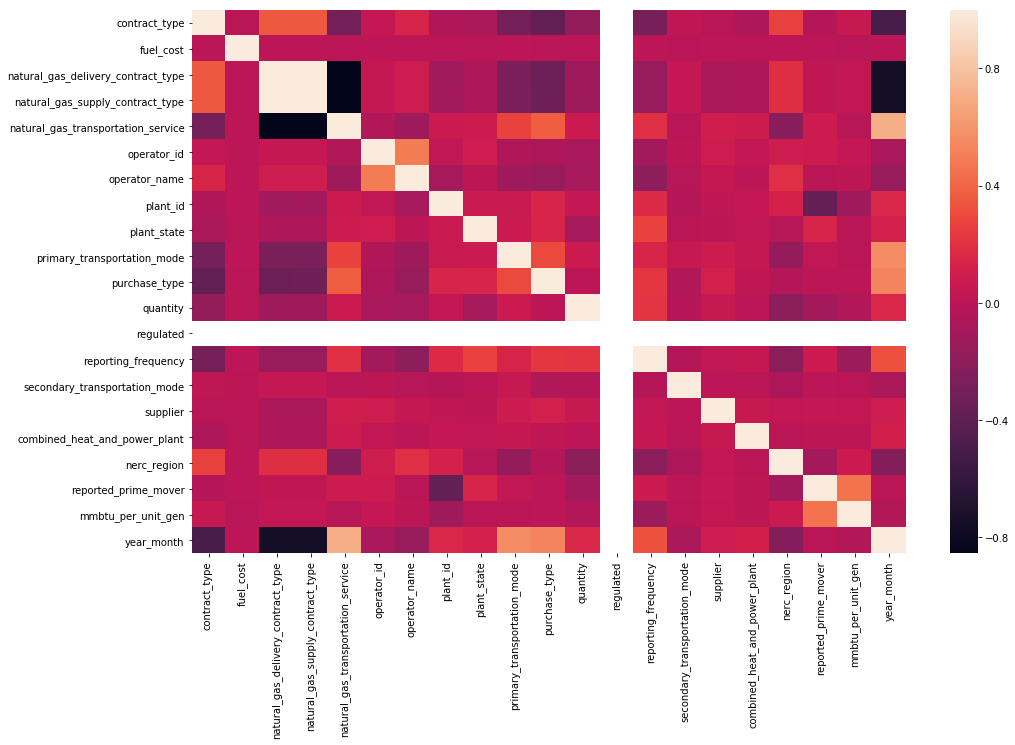

In [72]:
fig = plt.figure(figsize=(16,10))
import seaborn as sns
sns.heatmap(corr)

## Formatting fields for Modelling (One-Hot Encoding)

In [119]:
# defining a function to get Natural Gas entries as it gets repeated
def get_ng_(all_=True):
    df_ng = df[df["fuel_group"] == "Natural Gas"]
    df_ng = df_ng[ng_fields]
    
    # one-hot encoding fields
    not_encode = []
    to_encode = []
    for fld, fld_type in df_ng[ng_fields].dtypes.items():
        if "object" == fld_type:
            to_encode.append(fld)
        else:
            not_encode.append(fld)
    if all_: 
        temp1 = df_ng[not_encode].reset_index()
        temp2 = pd.get_dummies(df_ng[to_encode]).reset_index()
        df_ng = temp1.merge(temp2, on="index").set_index("index")
    else:
        df_ng = df_ng[not_encode]
    return df_ng
get_ng = get_ng_()

## Modelling

In [89]:
df_ng = get_ng


In [90]:
X = df_ng.drop(columns="fuel_cost")
y = df_ng.fuel_cost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [91]:
model = DecisionTreeRegressor(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

In [92]:
results.score(X_train, y_train)

0.9919233545242145

In [110]:
X = X[all_fields]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [111]:
model = DecisionTreeRegressor(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

In [93]:
results.score(X_test, y_test)

0.7166735279937464

In [95]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    print(a,b)


operator_name_Salt River Project 0.6640464707485532
year_month_2018-04 0.10936535081528541
quantity 0.08408246212322089
plant_id_54844 0.06221292924240232
operator_name_Union Electric Co - (MO) 0.03242861504488723
natural_gas_transportation_service_I 0.007148694133307686
year_month_2016-05 0.007007464274243404
year_month_2015-10 0.006586896748185402
year_month_2014-09 0.005917665490164446
plant_id_55939 0.004389791556030539
plant_state_VA 0.003499592607792013
purchase_type_S 0.001990503082968793
plant_id_55251 0.0018880855597469333
supplier_EL PASO NATURAL GAS 0.001821334261479033
plant_id_141 0.001267796496240084
plant_id_377 0.0012039702195725311
year_month_2016-08 0.0010904837057994685
plant_id_170 0.0009873803402609157
supplier_PANHANDLE EASTERN PIPELINE 0.0009442197034054522
supplier_MIDCONTINENT EXPRESS PIPELINE LLC 0.0005553880449298586
operator_name_MidAmerican Energy Co 0.0002711322962792845
reported_prime_mover_CT 0.00026067035120535403
year_month_2014-08 0.000244293295129489

plant_id_3295 0.0
plant_id_3298 0.0
plant_id_3325 0.0
plant_id_3344 0.0
plant_id_3393 0.0
plant_id_3403 0.0
plant_id_3405 0.0
plant_id_3406 0.0
plant_id_3456 0.0
plant_id_3457 0.0
plant_id_3459 0.0
plant_id_3476 0.0
plant_id_3478 0.0
plant_id_3482 0.0
plant_id_3484 0.0
plant_id_3485 0.0
plant_id_3548 0.0
plant_id_3559 0.0
plant_id_3576 0.0
plant_id_358 0.0
plant_id_3601 0.0
plant_id_3602 0.0
plant_id_3604 0.0
plant_id_3609 0.0
plant_id_3611 0.0
plant_id_3612 0.0
plant_id_3613 0.0
plant_id_3627 0.0
plant_id_3628 0.0
plant_id_3630 0.0
plant_id_3631 0.0
plant_id_3648 0.0
plant_id_3775 0.0
plant_id_3796 0.0
plant_id_3797 0.0
plant_id_3804 0.0
plant_id_3809 0.0
plant_id_389 0.0
plant_id_3944 0.0
plant_id_3946 0.0
plant_id_3982 0.0
plant_id_399 0.0
plant_id_3991 0.0
plant_id_3992 0.0
plant_id_400 0.0
plant_id_4005 0.0
plant_id_4014 0.0
plant_id_404 0.0
plant_id_4040 0.0
plant_id_4041 0.0
plant_id_4042 0.0
plant_id_4048 0.0
plant_id_4057 0.0
plant_id_4072 0.0
plant_id_4076 0.0
plant_id_4078 0

supplier_CSP_SALES 0.0
supplier_CYPRESS 0.0
supplier_CYPRESS GAS PIPELINE 0.0
supplier_CenterPt 0.0
supplier_Chesapeake 0.0
supplier_Chevron NG 0.0
supplier_Cimarex 0.0
supplier_ColumbiaTC 0.0
supplier_ConocoPhil 0.0
supplier_DAKOTA GASIFICATION COMPANY 0.0
supplier_DB ENERGY 0.0
supplier_DBET 0.0
supplier_DCP 0.0
supplier_DCPMM 0.0
supplier_DEAN VENTURES NATURAL GAS TRADING, LLC 0.0
supplier_DEFINITE ENERGY GROUP 0.0
supplier_DELTA ENERGY 0.0
supplier_DEM 0.0
supplier_DETM 0.0
supplier_DEVON CANADA 0.0
supplier_DEVON ENERGY 0.0
supplier_DEVON GAS SERVICES 0.0
supplier_DILLION ENERGY SERVICE,INC 0.0
supplier_DIRECT ENERGY BUSINESS MARKETING 0.0
supplier_DISTR ENSTAR NATURAL GAS 0.0
supplier_DISTR ENSTAR NATURAL GAS (#5 & #7) 0.0
supplier_DISTRIGAS OF MASSACHUSETTS 0.0
supplier_DOMINION 0.0
supplier_DOMINION HOPE 0.0
supplier_DOMINION PIPELINE 0.0
supplier_DOMINION TRANSMISSION 0.0
supplier_DPL ENERGY 0.0
supplier_DTE COAL SERVICES 0.0
supplier_DTE Energy 0.0
supplier_DTE GAS RES 0.0
su

nerc_region_NPCC 0.0
nerc_region_RFC 0.0
nerc_region_SERC 0.0
nerc_region_SPP 0.0
nerc_region_TRE 0.0
nerc_region_WECC 0.0
reported_prime_mover_CS 0.0
reported_prime_mover_GT 0.0
reported_prime_mover_IC 0.0
year_month_2008-01 0.0
year_month_2008-02 0.0
year_month_2008-03 0.0
year_month_2008-04 0.0
year_month_2008-05 0.0
year_month_2008-06 0.0
year_month_2008-07 0.0
year_month_2008-08 0.0
year_month_2008-09 0.0
year_month_2008-10 0.0
year_month_2008-11 0.0
year_month_2008-12 0.0
year_month_2009-01 0.0
year_month_2009-02 0.0
year_month_2009-03 0.0
year_month_2009-04 0.0
year_month_2009-05 0.0
year_month_2009-06 0.0
year_month_2009-07 0.0
year_month_2009-08 0.0
year_month_2009-09 0.0
year_month_2009-10 0.0
year_month_2009-11 0.0
year_month_2009-12 0.0
year_month_2010-01 0.0
year_month_2010-02 0.0
year_month_2010-04 0.0
year_month_2010-05 0.0
year_month_2010-06 0.0
year_month_2010-07 0.0
year_month_2010-08 0.0
year_month_2010-09 0.0
year_month_2010-10 0.0
year_month_2010-12 0.0
year_month_

### Field Reduction
Decision Tree Regressor sets a number of fields as zero-importance. Run the model iteratively, removing zero-important features at each step

In [120]:
def tree_loop(loops=10):
    saved_fields = []
    saved_scores = []
    saved_importances = []
    
    df_ng = get_ng
    X = df_ng.drop(columns="fuel_cost")
    y = df_ng.fuel_cost
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    model = DecisionTreeRegressor(random_state=23, max_depth=10)
    results = model.fit(X_train, y_train)
    
    for i in range(loops):
            remove_fields = []
            for a,b in zip(X.columns, results.feature_importances_):
                if b==0: remove_fields.append(a)
            all_fields = X.columns
            all_fields = [fld for fld in all_fields if fld not in remove_fields]
            
            X = X[all_fields]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
            model = DecisionTreeRegressor(random_state=23, max_depth=10)
            results = model.fit(X_train, y_train)
            score = results.score(X_test, y_test)
            if score >.9: 
                saved_fields.append(all_fields)
                saved_scores.append(score)
                saved_importances.append(results.feature_importances_)
            print(score)
    return saved_fields, saved_scores, saved_importances

In [121]:
flds,scores, importances = tree_loop()

0.9773679962492382
0.9409702644182063
0.8974660442346571
0.8764440887058466
0.9053768063599696
0.8123988959243735
0.9809886223838439
0.8990138374013745
0.9237998616493125
0.6476345079460761


In [102]:
scores

[0.984394192114683,
 0.9923208117798308,
 0.9841944773054945,
 0.902131405022617,
 0.9731868506306081]

In [123]:
for a,b in sorted(zip(flds[1], importances[1]), key=lambda x: x[1], reverse=True):
    print(a,b)

operator_name_Salt River Project 0.6058836110179739
quantity 0.25143129846793594
plant_id_54844 0.0825587049311784
supplier_PANHANDLE EASTERN PIPELINE 0.020514093267474588
year_month_2014-09 0.007763463053612252
natural_gas_supply_contract_type_I 0.006425927772802861
plant_id_55939 0.005836299685848295
year_month_2016-08 0.005290088879047681
operator_name_Nevada Power Co 0.0047477377672450445
year_month_2009-11 0.002396545280274108
natural_gas_transportation_service_F 0.0018298138070694902
plant_id_141 0.0017957052350919625
year_month_2015-02 0.0009137009166355738
supplier_MIDCONTINENT EXPRESS PIPELINE LLC 0.0007562497496502159
year_month_2015-11 0.0007347944660368791
year_month_2014-08 0.0003207727172402859
plant_id_7839 0.00029918621085860434
mmbtu_per_unit_gen 0.00016226606386225895
contract_type_C 8.415187676055828e-05
plant_id_170 7.430145796155172e-05
plant_id_8219 4.631592151374412e-05
year_month_2014-11 4.240864488098671e-05
reported_prime_mover_CA 2.8065050186252797e-05
contra

In [103]:
flds[1]

['quantity',
 'mmbtu_per_unit_gen',
 'contract_type_C',
 'natural_gas_transportation_service_F',
 'natural_gas_transportation_service_I',
 'plant_id_10761',
 'plant_id_141',
 'plant_id_147',
 'plant_id_170',
 'plant_id_54844',
 'plant_id_55129',
 'plant_id_55234',
 'plant_id_55939',
 'plant_id_7839',
 'primary_transportation_mode_PL',
 'purchase_type_C',
 'supplier_EL PASO NATURAL GAS',
 'supplier_KINDER MORGAN',
 'supplier_MIDCONTINENT EXPRESS PIPELINE LLC',
 'reported_prime_mover_CT',
 'reported_prime_mover_GT',
 'reported_prime_mover_ST',
 'year_month_2009-09',
 'year_month_2010-05',
 'year_month_2010-12',
 'year_month_2011-05',
 'year_month_2012-11',
 'year_month_2013-02',
 'year_month_2013-06',
 'year_month_2013-11',
 'year_month_2014-05',
 'year_month_2014-08',
 'year_month_2014-09',
 'year_month_2014-11',
 'year_month_2015-02',
 'year_month_2015-04',
 'year_month_2015-11',
 'year_month_2016-01',
 'year_month_2016-05',
 'year_month_2016-08',
 'year_month_2016-11',
 'year_month_20

In [104]:
df_ng = get_ng
X = df_ng[flds[1]]
y = df_ng.fuel_cost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
model = DecisionTreeRegressor(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)
results.score(X_test, y_test)

0.9721763934416128

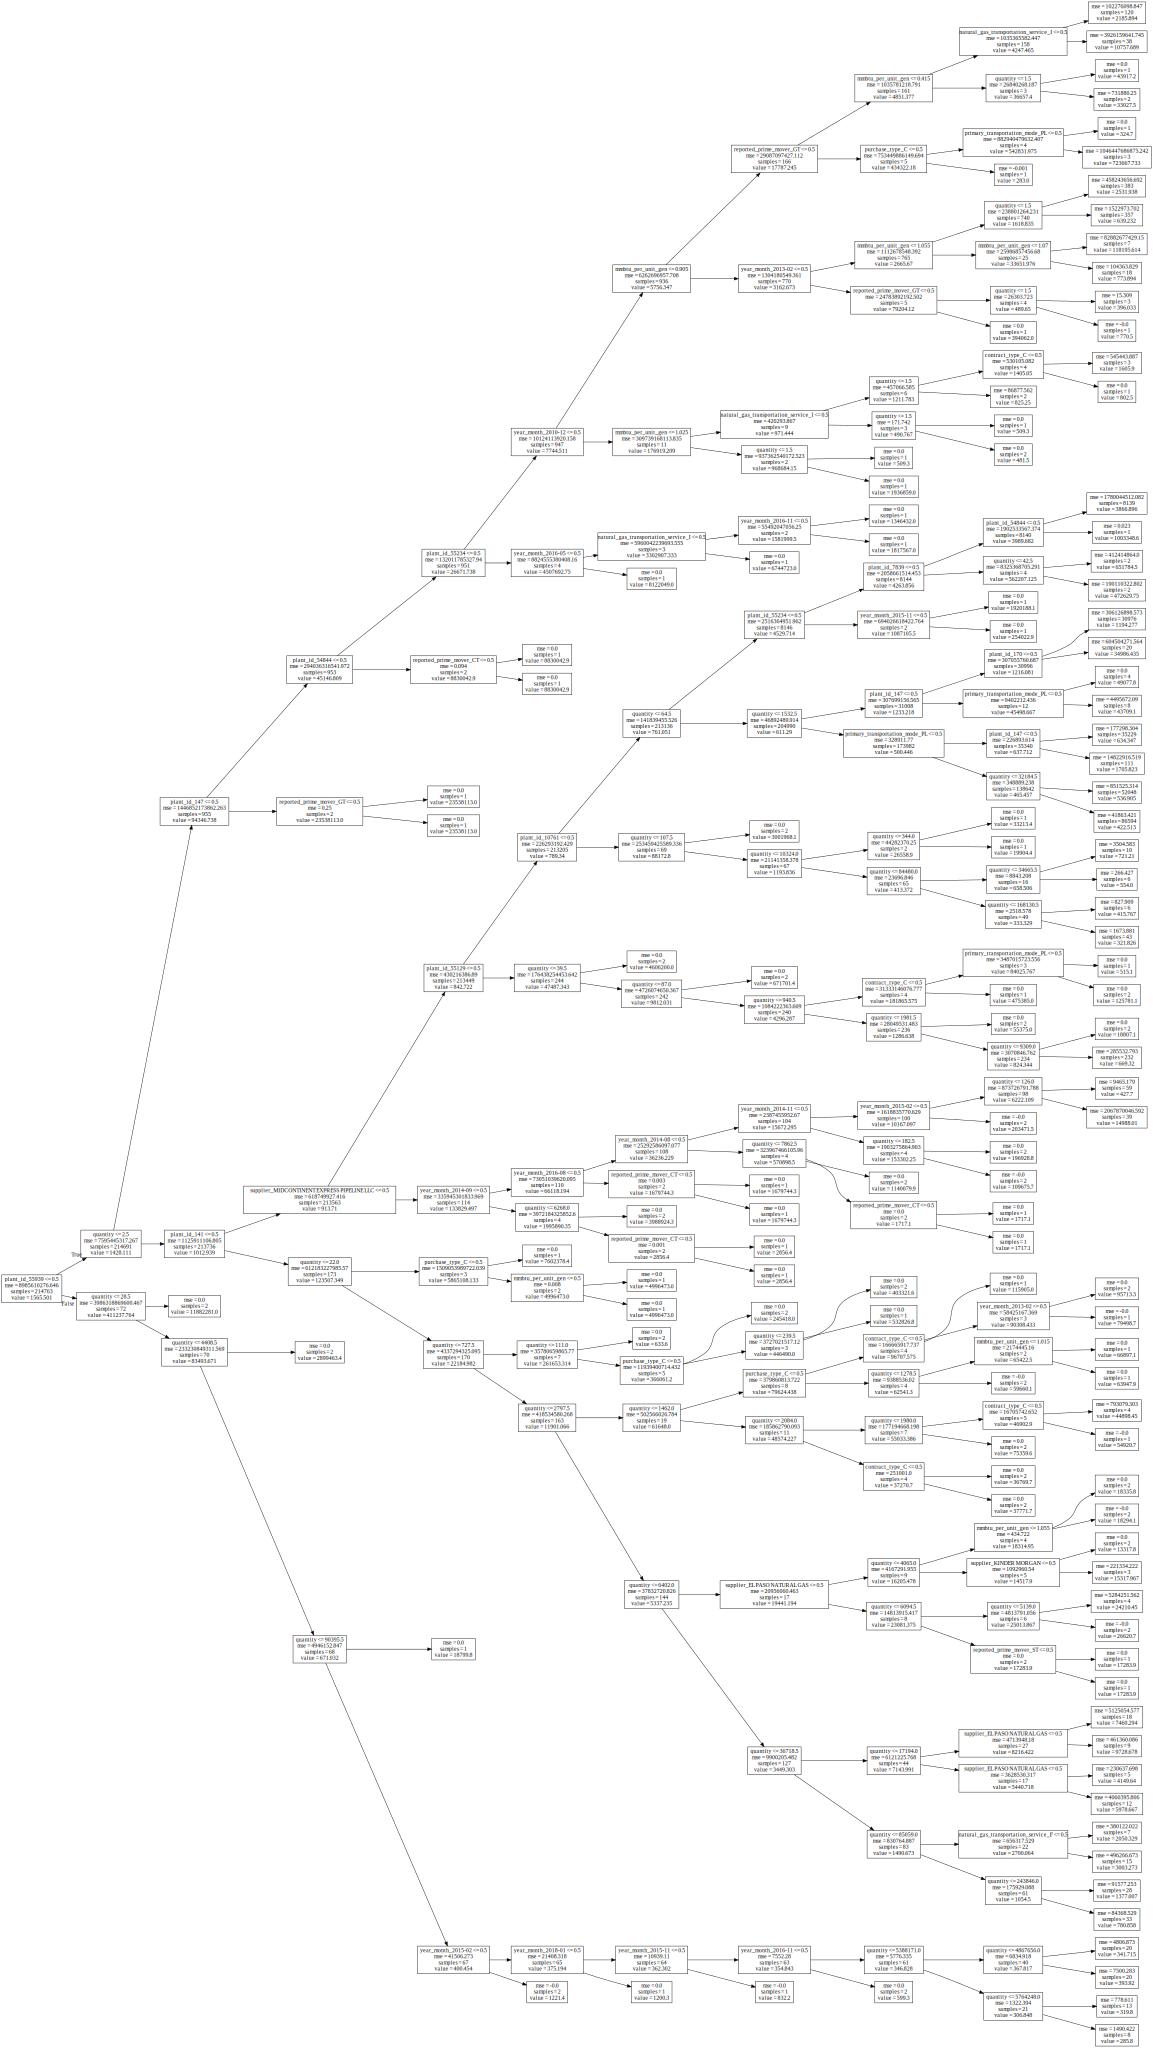

In [106]:
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG
graph = Source(export_graphviz(results, rotate=True, out_file=None, feature_names=X.columns))
SVG(graph.pipe(format='svg'))

In [107]:
graph.format = 'png'
graph.render('dtree_render_h',view=True)

'dtree_render_h.png'

In [139]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    print(a,b)

operator_id_16572.0 0.7455673180442225
year_month_2018-04 0.07885021075949052
plant_state_VA 0.061047934445932484
operator_id_19436.0 0.033554929465878285
reported_prime_mover_CA 0.01669629632740949
mmbtu_per_unit_gen 0.00903947423182198
natural_gas_delivery_contract_type_I 0.007598053847840813
operator_name_Nevada Power Co 0.007488171333737557
quantity 0.007368481798263049
year_month_2016-05 0.007291765237000717
supplier_MIDCONTINENT EXPRESS PIPELINE LLC 0.00593076255433258
reported_prime_mover_CT 0.003546245430749169
year_month_2016-08 0.003195648441148687
purchase_type_S 0.0023854183417931214
supplier_ANR 0.001958332427049443
primary_transportation_mode_PL 0.0018891080640075274
operator_id_7294.0 0.001247350909602333
operator_id_814.0 0.0010305003877058149
supplier_TENNESSEE GAS PIPELINE 0.0009614294997313059
reported_prime_mover_ST 0.0009197776993939002
year_month_2014-09 0.0007641506229105693
operator_name_MidAmerican Energy Co 0.00028196607891629616
supplier_EL PASO NATURAL GAS 0

In [191]:
df_16572 = df[df["operator_id"] == 16572]


In [192]:
grouped = df.groupby("year_month").mean()

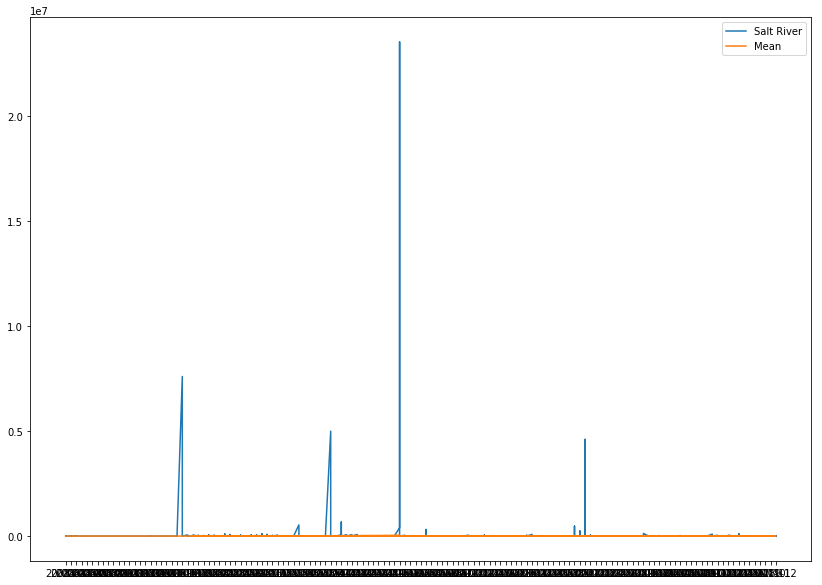

In [195]:
fig = plt.figure(figsize=(14,10))
plt.plot(df_16572["year_month"], df_16572["fuel_cost"], label="Salt River")
plt.plot(grouped.index, grouped["fuel_cost"], label="Mean")
plt.legend()

# Classification of Price Spikes

Rather than predicting prices, I want to know what causes the extraordinary prices. 

In [126]:
df_ng = get_ng

In [132]:
df_ng = df_ng[df_ng.fuel_cost >0]

In [129]:
df_ng.fuel_cost.describe()

count    2.684540e+05
mean     1.639819e+03
std      1.081501e+05
min     -7.193000e+03
25%      3.418000e+02
50%      4.333000e+02
75%      5.486000e+02
max      2.353811e+07
Name: fuel_cost, dtype: float64

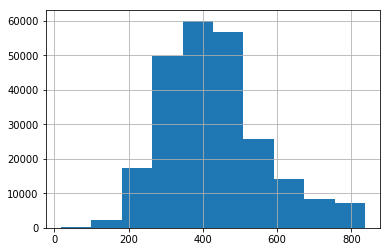

In [134]:
df_ng[df_ng.fuel_cost < df_ng.fuel_cost.quantile(.9)].fuel_cost.hist()

In [ ]:
df_ng[df_ng.fuel_cost < df_ng.fuel_cost.quantile(.1)].fuel_cost.hist()

### Defining excess prices as those above 90th percentile, which is over twice the median.

In [141]:
df_ng["price_spike"] = 1*(df_ng.fuel_cost > df_ng.fuel_cost.quantile(.9))

/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [142]:
df_ng.head()

,fuel_cost,quantity,mmbtu_per_unit_gen,contract_type_C,contract_type_NC,contract_type_S,natural_gas_delivery_contract_type_F,natural_gas_delivery_contract_type_I,natural_gas_supply_contract_type_F,natural_gas_supply_contract_type_I,natural_gas_transportation_service_F,natural_gas_transportation_service_I,operator_id_10000,operator_id_10005,operator_id_1015,operator_id_10171,operator_id_10325,operator_id_10376,operator_id_10620,operator_id_10623,operator_id_11018,operator_id_11142,operator_id_11208,operator_id_11241,operator_id_11249,operator_id_11269,operator_id_11292,operator_id_11479,operator_id_11571,operator_id_11732,operator_id_11740,operator_id_11806,operator_id_12199,operator_id_12208,operator_id_12341,operator_id_12524,operator_id_12647,operator_id_12667,operator_id_12685,operator_id_12686,operator_id_12745,operator_id_12796,operator_id_12807,operator_id_12927,operator_id_1307,operator_id_13100,operator_id_13143,operator_id_13228,operator_id_13337,operator_id_13407,operator_id_13478,operator_id_13488,operator_id_13683,operator_id_13756,operator_id_13781,operator_id_13809,operator_id_13994,operator_id_14006,operator_id_14063,operator_id_14077,operator_id_14127,operator_id_14194,operator_id_14232,operator_id_14268,operator_id_14328,operator_id_14354,operator_id_14381,operator_id_14534,operator_id_14605,operator_id_14610,operator_id_15143,operator_id_15248,operator_id_15296,operator_id_15466,operator_id_15470,operator_id_15472,operator_id_15473,operator_id_15474,operator_id_15500,operator_id_15776,operator_id_15783,operator_id_16088,operator_id_16181,operator_id_16183,operator_id_16295,operator_id_16534,operator_id_16572,operator_id_16604,operator_id_16609,operator_id_16655,operator_id_1692,operator_id_17166,operator_id_17539,operator_id_17543,operator_id_17554,operator_id_17568,operator_id_17583,operator_id_17609,operator_id_17632,operator_id_17633,operator_id_17697,operator_id_17698,operator_id_17718,operator_id_17828,operator_id_17833,operator_id_17874,operator_id_18315,operator_id_18445,operator_id_18454,operator_id_18488,operator_id_18642,operator_id_18715,operator_id_189,operator_id_19281,operator_id_19436,operator_id_195,operator_id_19545,operator_id_19558,operator_id_19728,operator_id_19804,operator_id_19876,operator_id_20169,operator_id_20421,operator_id_20447,operator_id_20847,operator_id_20856,operator_id_20858,operator_id_20860,operator_id_20910,operator_id_21048,operator_id_2144,operator_id_21554,operator_id_2172,operator_id_22053,operator_id_22500,operator_id_23279,operator_id_2409,operator_id_24211,operator_id_2442,operator_id_24431,operator_id_2507,operator_id_25422,operator_id_2548,operator_id_26253,operator_id_29116,operator_id_298,operator_id_30151,operator_id_3046,operator_id_3203,operator_id_3258,operator_id_3265,operator_id_3355,operator_id_343,operator_id_3486,operator_id_3522,operator_id_3542,operator_id_3660,operator_id_3702,operator_id_3892,operator_id_39347,operator_id_3989,operator_id_40211,operator_id_40229,operator_id_40307,operator_id_4045,operator_id_40577,operator_id_40582,operator_id_40606,operator_id_40613,operator_id_40614,operator_id_4062,operator_id_4180,operator_id_4226,operator_id_4254,operator_id_4363,operator_id_4716,operator_id_4922,operator_id_49893,operator_id_49974,operator_id_50111,operator_id_50168,operator_id_50172,operator_id_5063,operator_id_5107,operator_id_5109,operator_id_5269,operator_id_5416,operator_id_5532,operator_id_55729,operator_id_5580,operator_id_55936,operator_id_55937,operator_id_55987,operator_id_56211,operator_id_56505,operator_id_56771,operator_id_56815,operator_id_5695,operator_id_5701,operator_id_57393,operator_id_5860,operator_id_58620,operator_id_590,operator_id_599,operator_id_59917,operator_id_61137,operator_id_61919,operator_id_62032,operator_id_6204,operator_id_6235,operator_id_6452,operator_id_6455,operator_id_6526,operator_id_6616,operator_id_6775,operator_id_6779,operator_id_6909,operator_id_6958,operator_id_7004,operator_id_7140,operator_id_7

In [147]:
X = df_ng.drop(columns=["price_spike", "fuel_cost"])
y = df_ng.price_spike

In [153]:
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
model = DecisionTreeClassifier(random_state=23, max_depth=10, max_leaf_nodes=10)
results = model.fit(X_train, y_train)
results.score(X_test, y_test)

0.9384417664698541

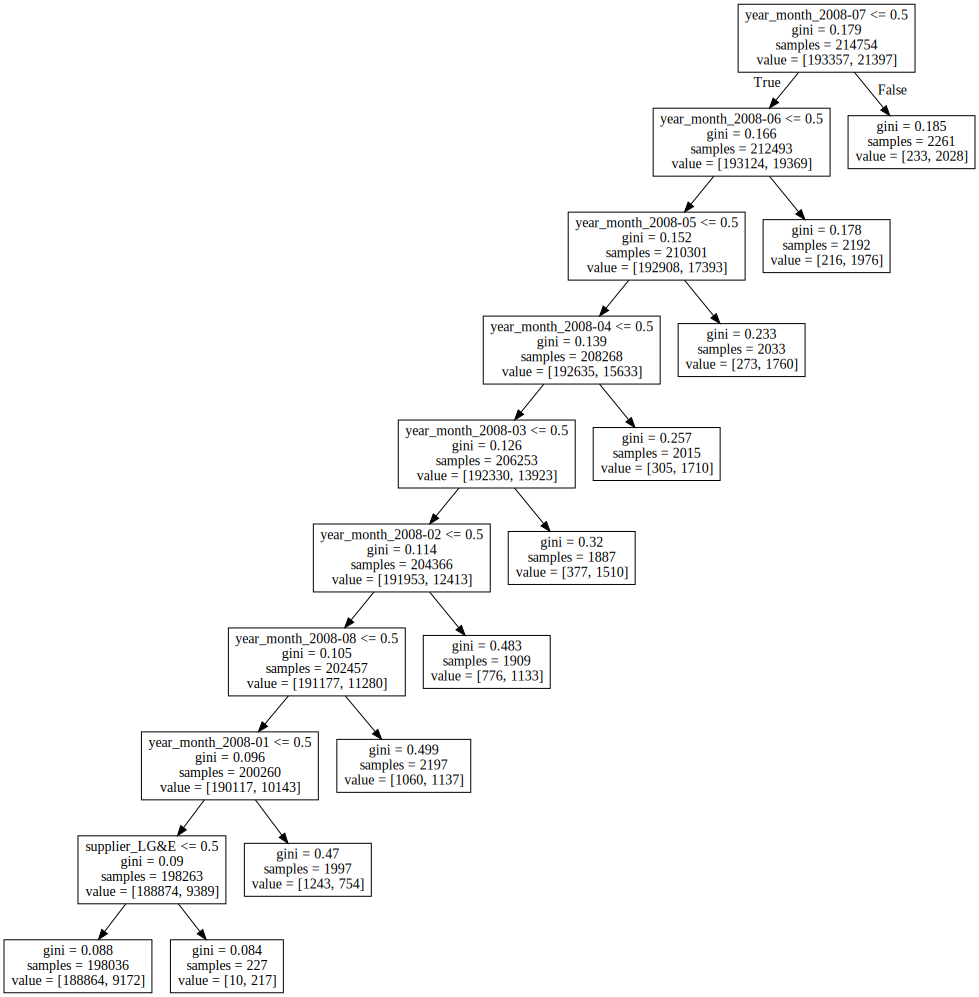

In [154]:
graph = Source(export_graphviz(results, out_file=None, feature_names=X.columns))
SVG(graph.pipe(format='svg'))

In [155]:
graph.format = 'png'
graph.render('dtree_render',view=True)

'dtree_render.png'

In [157]:
df_ng[df_ng["supplier_LG&E"]==1].fuel_cost.max()

8480.7

In [167]:
temp = df[(df["fuel_group"] == "Natural Gas") & (df.fuel_cost > df.fuel_cost.quantile(.9))]

In [161]:
grouped.sort_values("fuel_cost", ascending=False)

,average_ash_content,average_heat_content,average_mercury_content,average_sulfur_content,chlorine_content,coalmine_msha_id,energy_source,fuel_cost,fuel_group,moisture_content,month,operator_id,operator_name,plant_id,plant_name,plant_state,quantity,regulated,reporting_frequency,year,plant_id_gen,combined_heat_and_power_plant,nuclear_unit_id,plant_name_gen,operator_name_gen,operator_id_gen,state_gen,census_region,reserved_,naics_code,eia_sector_number,sector_name,reported_prime_mover,reported_fuel_type_code,aer_fuel_type_code,reserved_1,reserved_2,physical_unit_label,total_fuel_consumption_quantity,electric_fuel_consumption_quantity,total_fuel_consumption_mmbtu,elec_fuel_consumption_mmbtu,net_generation_megawatthours,year_gen,quantity_gen,elec_quantity_gen,mmbtu_per_unit_gen,tot_mmbtu_gen,elec_mmbtu_gen,netgen_gen,year_month
supplier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
KINDER MORGAN,0.0,1.204,0.0,0.0,NaN,0,NG,23538113.0,Natural Gas,NaN,12,5701,Southwestern Electric Power Co,8068,Winchester Power Park,TX,4304598,REG,M,2019,59338,N,0,Winchester Power Park,Southwestern Electric Power Co,55937,TX,WSC,NaN,22,2,NAICS-22 Non-Cogen,ST,NG,NG,NaN,NaN,mcf,54924646,54924646,56741674,56741674,5433863,2019,7488991,7488991,1.18,7668727,7668727,664521,2019-04
VIRGINIA POWER SERVICES ENERGY,0.0,1.210,0.0,0.0,NaN,0,NG,11882281.0,Natural Gas,NaN,12,19876,Virginia Electric & Power Co,7839,Yorktown,VA,6430560,REG,M,2019,59913,N,0,Yorktown,Virginia Electric & Power Co,19876,VA,SAT,NaN,22,1,Electric Utility,ST,NG,NG,NaN,NaN,mcf,57192108,57192108,58893128,58893128,8526840,2019,6378218,6378218,1.10,6633347,6633347,1038349,2019-04
MISSISSIPPI RIVER TRANS,0.0,1.061,0.0,0.0,NaN,0,NG,8122049.0,Natural Gas,NaN,12,814,Union Electric Co - (MO),913,Venice,MO,1042760,REG,M,2019,55496,N,0,Venice,Union Electric Co - (MO),19436,MO,WSC,NaN,22,1,Electric Utility,ST,NG,NG,NaN,NaN,mcf,2078152,2078152,2107147,2107147,188201,2019,1042760,1042760,1.06,1065701,1065701,93748,2019-04
EL PASO NATURAL GAS,0.0,1.076,0.0,0.0,NaN,0,NG,7602378.4,Natural Gas,NaN,12,7349,Tucson Electric Power Co,8068,Santan,TX,3800780,REG,M,2019,59784,N,0,Santan,Tucson Electric Power Co,30151,TX,WSC,NaN,22,2,NAICS-22 Non-Cogen,ST,NG,NG,NaN,NaN,mcf,27215358,27215358,28075878,28075878,2522360,2019,3066238,3066238,1.10,3133695,3133695,291121,2019-04
PANHANDLE EASTERN PIPELINE,0.0,1.148,0.0,0.0,NaN,0,NG,6744723.0,Natural Gas,NaN,12,7004,Union Electric Co - (MO),7964,South Harper,OH,591883,REG,M,2018,56151,N,0,South Harper,Union Electric Co - (MO),56211,OH,WNC,NaN,22,1,Electric Utility,GT,NG,NG,NaN,NaN,mcf,1928571,1928571,2048142,2048142,210847,2018,865179,865179,1.15,865179,865179,71702,2018-12
MIDCONTINENT EXPRESS PIPELINE LLC,0.0,1.125,0.0,0.0,NaN,0,NG,3988924.3,Natural Gas,NaN,12,11241,Entergy Louisiana LLC,55467,Ouachita,LA,1389740,REG,M,2019,55467,N,0,Ouachita,Entergy Louisiana LLC,11241,LA,WSC,NaN,22,1,Electric Utility,CT,NG,NG,NaN,NaN,mcf,33260005,33260005,34432809,34432809,2980985,2019,3651711,3651711,1.06,3746655,3746655,327799,2019-04
SOUTHWEST GAS,0.0,1.068,0.0,0.0,NaN,0,NG,3001968.1,Natural Gas,NaN,12,5695,Tucson Electric Power Co,6088,Urquhart,SC,2827643,REG,M,2019,55077,N,0,Urquhart,Tucson Electric Power Co,24211,SC,WSC,NaN,22,1,Electric Utility,ST,NG,NG,NaN,NaN,mcf,15452701,15452701,15966748,15966748,2032466,2019,2289269,2289269,1.05,2387708,2387708,206883,2019-04
ENABLE GAS TRANSMISSION LLC,0.0,1.051,0.0,0.0,NaN,0,NG,2724732.5,Natural Gas,NaN,12,924,Southwestern Electric Power Co,8059,Wilkes,TX,2586422,REG,M,2019,56565,N,0,Wilkes,Southwestern Electric Power Co,17698,TX,WSC,NaN,22,1,Electric Utility,ST,NG,NG,NaN,NaN,mcf,24931031,24931031,25490065,25490065,2240702,2019,2575051,2575051,1.04,2628576,2628576,248278,2019-04
VARIOUS (NATURAL GAS SPOT PURCHASES ONLY),0.0,1.238,0.0,0.0,NaN,0,NG,2430546.7,Natural Gas,NaN,12,9191,Wisconsin Public Service Corp,8853,Zuni,WV,11442447,REG,M,2019,57943,Y,0,Zuni,Wisconsin Public Service Corp,58620,WV,WSC,NaN,32411,1,Electric Utility,ST,NG,

In [172]:
temp.supplier.value_counts()

VARIOUS (NATURAL GAS SPOT PURCHASES ONLY)        743
VARIOUS                                          717
VIRGINIA POWER SERVICES ENERGY                   538
Sequent                                          328
VPSE                                             314
EL PASO NATURAL GAS                              272
MIDAMERICAN ENERGY                               235
LG&E                                             227
MACQUARIE COOK                                   210
FLORIDA GAS                                      200
TENASKA MARKETING VENTURES                       185
ONEOK                                            170
POWEREX                                          170
constellation                                    168
B P ENERGY                                       164
SOUTHWEST GAS                                    157
TENASKA MARKETING                                157
CORAL                                            154
MUNIGAS - BP ENERGY                           

AttributeError: 'DataFrame' object has no attribute 'Year2'